In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
from itertools import product
from typing import Tuple, Dict

# Gridworld

In Gridworld, we need an agent to move from an initial position to an end position (blue and red positions in the drawing below)

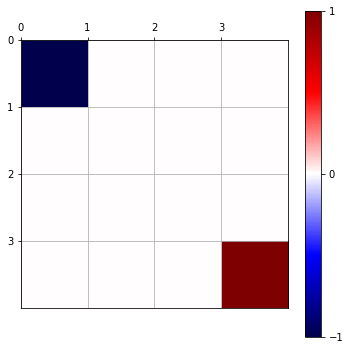

In [2]:
GRID_SIZE = 4
START_VALUE = -1
END_VALUE = 1
START_POS = (0,0)
END_POS = (3,3)

grid = np.zeros((GRID_SIZE, GRID_SIZE))
grid[START_POS] = START_VALUE
grid[END_POS] = END_VALUE

def visualize_grid(grid):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.set_xlim(0,GRID_SIZE)
    ax.set_ylim(GRID_SIZE,0)
    ax.set_xticks(list(range(GRID_SIZE)))
    ax.set_yticks(list(range(GRID_SIZE)))
    ax.imshow(grid, extent=(0, GRID_SIZE, GRID_SIZE, 0), cmap='seismic')
    ax.grid(True, 'major', 'both')
    ax.xaxis.tick_top()
    fig.colorbar(cm.ScalarMappable(cmap='seismic', norm=Normalize(-1,1)), 
        ax=ax, ticks=[-1, 0, 1])
    plt.show()

visualize_grid(grid)

We need the agent to move from the blue position to the red position using the following actions:

In [3]:
from enum import Enum

class Action(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

The rewards are +1 for getting to the end, -1 for trying to move out of bounds, 0 for any intermediate move.

In [18]:
CURRENT_STATE = START_POS

def in_bounds(y,x):
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE

def reached_target(st1):
    return st1 == END_POS

def get_reward(st, a, st1):
    if st == st1:
        # Agent stayed still or tried to go of bounds
        return -1
    if reached_target(st1):
        # Victory!
        return 1
    else:
        # Intermediate action
        return 0

def execute_action(st:Tuple, action:Action):
    if action == Action.UP:
        st_1 = (st[0]+1, st[1])
    elif action == Action.DOWN:
        st_1 = (st[0]-1, st[1])
    elif action == Action.LEFT:
        st_1 = (st[0], st[1]-1)
    elif action == Action.RIGHT:
        st_1 = (st[0], st[1]+1)
    if not in_bounds(*st_1):
        st_1 = st
    rt = get_reward(st, action, st_1)
    return st_1, rt


Suppose that the policy for the agent is such that a random action is selected each time.

In [19]:
random_policy = {
    (si, sj): {
        Action.UP: 1/4,
        Action.RIGHT: 1/4,
        Action.DOWN: 1/4,
        Action.LEFT: 1/4 
    }
    for si, sj in product(range(GRID_SIZE), repeat=2)
}

We implement a function to play a whole episode according to a policy and return the sequence of states, actions and rewards

In [58]:
def select_action_according_to_policy(current_state: Tuple[int,int], 
        policy:Dict[Tuple[int,int], Dict[Action, float]])-> Action:
    max_val = max(policy[current_state].values())
    # Randomly break ties
    keys = [key for key, value in policy[current_state].items() if value == max_val]
    choice = np.random.choice(keys)
    return choice

def select_random_action(current_state: Tuple[int,int], 
        policy:Dict[Tuple[int,int], Dict[Action, float]])-> Action:
    return np.random.choice(list(policy[current_state].keys()))

def play_episode(policy:Dict[Tuple[int, int], Dict[Action,float]], 
        start_state:Tuple[int, int], epsilon:float=0.1):
    states = [START_POS]
    actions = []
    rewards = []
    current_state = start_state
    while not reached_target(current_state):
        # Epsilon-greedy selection
        if np.random.random() <= epsilon:
            action = select_random_action(current_state, policy)
        else:
            action = select_action_according_to_policy(current_state, policy)
        next_state, reward = execute_action(current_state, action)
        current_state = next_state
        states.append(next_state)
        actions.append(action)
        rewards.append(reward)
    return states, actions, rewards

We use a **first-visit Monte Carlo method** to approximate the state-value function and the action-value function drawing samples from the space of possible games.

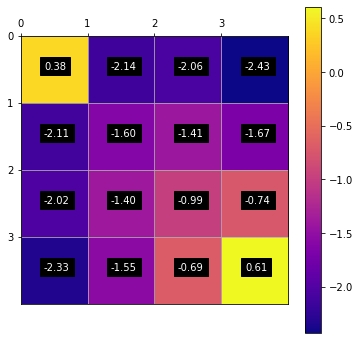

In [83]:
def visualize_Vs(Vs):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.set_xlim(0,GRID_SIZE)
    ax.set_ylim(GRID_SIZE,0)
    ax.set_xticks(list(range(GRID_SIZE)))
    ax.set_yticks(list(range(GRID_SIZE)))
    ax.imshow(Vs, extent=(0, GRID_SIZE, GRID_SIZE, 0), cmap='plasma')
    ax.grid(True, 'major', 'both')
    ax.xaxis.tick_top()
    fig.colorbar(cm.ScalarMappable(cmap='plasma', norm=Normalize(np.amin(Vs), np.amax(Vs))), 
        ax=ax)
    for i, el in enumerate(Vs.flatten()):
        ax.text(i % GRID_SIZE+0.35, i // GRID_SIZE+0.5, '{:.2f}'.format(el), fontdict={
            'color': 'white', 'backgroundcolor': 'black'
        })
    plt.show()

def first_visit_MC_V(policy:Dict[Tuple[int, int], Dict[Action,float]], 
        episodes_to_play:int=1000, discount=0.9):
    states = policy.keys()
    V = {st: np.random.random() for st in states}
    Returns = {st: [] for st in states}
    for i in range(episodes_to_play):
        sts, acts, rews = play_episode(policy, START_POS)
        cumulative_reward = 0
        # Remove last state
        sts.pop()
        for step in range(len(rews)-1, 0, -1):
            cumulative_reward = discount*cumulative_reward + rews[step]
            if not sts[step] in sts[:step]:
                Returns[sts[step]].append(cumulative_reward) # The cumulative reward is appended only once for the first visit method
                V[sts[step]] = np.mean(Returns[sts[step]])   # Compute average of rewards for V
    return V


Vs = first_visit_MC_V(random_policy, episodes_to_play=1000)
Vs_array = np.array([[Vs[i,j] for j in range(GRID_SIZE)] for i in range(GRID_SIZE)])
visualize_Vs(Vs_array)

Now we could move an agent from start to end based on always choosing the next maximum value.